In [38]:
from PIL import Image, ImageDraw, ImageFont
import pytesseract
from transformers import MarianMTModel, MarianTokenizer
import string
import textwrap
from ultralytics import YOLO

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [3]:
pytesseract 

<module 'pytesseract' from 'c:\\Users\\yasser.sakhraoui\\Desktop\\ipssi\\final_project\\.venv\\Lib\\site-packages\\pytesseract\\__init__.py'>

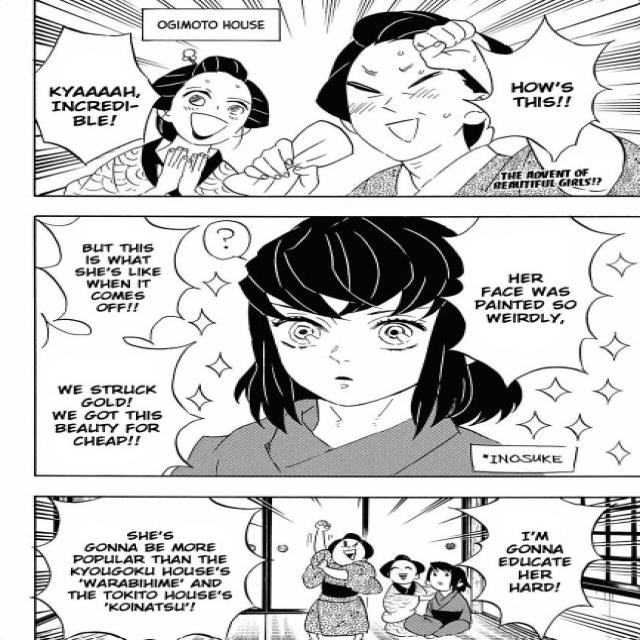

In [4]:
image = Image.open("../data/train/images/DS_1_jpg.rf.835fca3ad609d5790ad742aab2abc2e7.jpg")
image

In [5]:
english_text = pytesseract.image_to_string(image)
english_text

''

### Helsinki Model

In [6]:
model_name = 'Helsinki-NLP/opus-mt-en-fr'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [7]:
english_text = "Hello World"

In [8]:
inputs = tokenizer(english_text, return_tensors="pt", padding=True, truncation=True)
translated = model.generate(**inputs)
french_text = tokenizer.decode(translated[0], skip_special_tokens=True)

print(french_text)

Bonjour le monde


In [9]:
def translator(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated = model.generate(**inputs)
    french_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return french_text

In [10]:
translator('Hello World')

'Bonjour le monde'

In [ ]:
translator('Eeeeeeee !!')

'Eeeeeeeeee !!'

In [9]:
translator('Woooooow !!')

'Woooooow !!'

### Using YOLO boxes

In [24]:
image_path = "../data/train/images/DS_1_jpg.rf.835fca3ad609d5790ad742aab2abc2e7.jpg"
label_path = "../data/train/labels/DS_1_jpg.rf.835fca3ad609d5790ad742aab2abc2e7.txt"
image = Image.open(image_path)
width, height = image.size

In [12]:
print(f"Width : {width}\nHeight : {height}")

Width : 640
Height : 640


In [13]:
yolo_boxes = []
with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 5:
            _, x_center, y_center, w, h = map(float, parts)
            yolo_boxes.append((x_center, y_center, w, h))

In [14]:
yolo_boxes

[(0.35234375, 0.378125, 0.04609375, 0.04453125),
 (0.3515625, 0.371875, 0.03203125, 0.0328125),
 (0.18359375, 0.4328125, 0.1375, 0.1125),
 (0.846875, 0.146875, 0.10859375, 0.0453125),
 (0.8203125, 0.4671875, 0.165625, 0.0828125),
 (0.16875, 0.64921875, 0.1796875, 0.1),
 (0.14765625, 0.16640625, 0.14921875, 0.06640625),
 (0.23515625, 0.89140625, 0.25703125, 0.1328125),
 (0.8328125, 0.87734375, 0.1109375, 0.0984375),
 (0.85390625, 0.2796875, 0.18203125, 0.0359375)]

In [15]:
model_name = 'Helsinki-NLP/opus-mt-en-fr'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [16]:
def yolo_to_pixel(box):
    x_center, y_center, w, h = box
    x_center *= width
    y_center *= height
    w *= width
    h *= height
    left = int(x_center - w / 2)
    top = int(y_center - h / 2)
    right = int(x_center + w / 2)
    bottom = int(y_center + h / 2)
    return (left, top, right, bottom)

In [17]:
def clean_text(region):
    text = pytesseract.image_to_string(region).strip()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('- ', '-')
    punct_to_remove = string.punctuation.replace("'", "")
    translator = str.maketrans('', '', punct_to_remove)
    cleaned_text = text.translate(translator).lower()
    return cleaned_text

In [18]:
for i, box in enumerate(yolo_boxes):
    region = image.crop(yolo_to_pixel(box))
    text = clean_text(region)
    if text:
        print(f"\nBubble {i+1}:\n==> Text: {text}")
        tokens = tokenizer(text, return_tensors="pt", truncation=True)
        translated = model.generate(**tokens)
        french = tokenizer.decode(translated[0], skip_special_tokens=True)
        print(f"==> French: {french}")
    else:
        print(f"\nBubble {i+1}: [No text detected]")


Bubble 1: [No text detected]

Bubble 2: [No text detected]

Bubble 3:
==> Text: but this is what she's like when it  offi
==> French: Mais c'est comme ça qu'elle est quand c'est fi

Bubble 4:
==> Text: how's this
==> French: Comment ça se passe ?

Bubble 5:
==> Text: her face was painted so weirdly
==> French: son visage a été peint si bizarrement

Bubble 6:
==> Text: we struck goldi we got this beauty for cheap
==> French: nous avons frappé Goldi nous avons eu cette beauté pour bon marché

Bubble 7:
==> Text: kyaaaah incredible
==> French: kyaaaah incroyable

Bubble 8:
==> Text: she's gonna be more popular than the kyougoku house's warabihime’ and the tokito holise's coinatsl
==> French: Elle va être plus populaire que la warabihime de la maison de kyugoku et la pièce de monnaie du tokito Holise.

Bubble 9:
==> Text: rm  educate her hard
==> French: rm l'éduquer dur

Bubble 10: [No text detected]


### Draw translated text

In [34]:
draw = ImageDraw.Draw(image)
draw

In [35]:
try:
    font = ImageFont.truetype("arial.ttf", size=14) 
except:
    font = ImageFont.load_default()

In [29]:
def draw_wrapped_text(draw, box, text, font):
    left, top, right, bottom = box
    box_width = right - left
    box_height = bottom - top
    lines = textwrap.wrap(text, width=25)

    bbox = font.getbbox("A")
    line_height = bbox[3] - bbox[1] + 2
    total_height = line_height * len(lines)

    y_text = top + (box_height - total_height) // 2

    for line in lines:
        bbox_line = font.getbbox(line)
        line_width = bbox_line[2] - bbox_line[0]
        x_text = left + (box_width - line_width) // 2
        draw.text((x_text, y_text), line, font=font, fill="black")
        y_text += line_height

In [30]:
for i, box in enumerate(yolo_boxes):
    region_box = yolo_to_pixel(box)
    region = image.crop(region_box)
    text = clean_text(region)
    if text:
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        translated = model.generate(**inputs)
        french = tokenizer.decode(translated[0], skip_special_tokens=True)

        draw.rectangle(region_box, fill="white")
        draw_wrapped_text(draw, region_box, french, font)

# Save or show result
# image.save("translated_manga.jpg")
image.show()

In [31]:
from deep_translator import GoogleTranslator

In [32]:
GoogleTranslator(source='en', target='fr').translate("keep it up, you are awesome")

'Continuez comme ça, tu es génial'

In [33]:
image_path = "../data/train/images/DS_1_jpg.rf.835fca3ad609d5790ad742aab2abc2e7.jpg"
label_path = "../data/train/labels/DS_1_jpg.rf.835fca3ad609d5790ad742aab2abc2e7.txt"
image = Image.open(image_path)
width, height = image.size

In [36]:
for i, box in enumerate(yolo_boxes):
    region_box = yolo_to_pixel(box)
    region = image.crop(region_box)
    text = clean_text(region)
    if text:
        french = GoogleTranslator(source='en', target='fr').translate(text)
        draw.rectangle(region_box, fill="white")
        draw_wrapped_text(draw, region_box, french, font)

# Save or show result
# image.save("translated_manga.jpg")
image.show()

### USE TRAINED MODEL :

In [39]:
model = YOLO("yolo_scan_model.pt")

In [41]:
image = ['../data/test/images/mg_3_jpg.rf.1747ad13f55277bfb0f2596c9f6c5fdb.jpg']
results = model(image, conf=0.1,iou = 0.2)

for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk

0: 640x640 9 bubbles, 291.8ms
Speed: 6.6ms preprocess, 291.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


In [44]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image

# === Load trained YOLO model ===
model = YOLO("yolo_scan_model.pt")

# === Paths ===
image_folder = Path("../data/test/images")
output_label_folder = Path("../data/test/predicted_labels")
output_label_folder.mkdir(parents=True, exist_ok=True)

# === Function to save YOLO-format labels ===
def save_yolo_boxes(results, image_path, save_dir):
    img_width, img_height = results.orig_shape[1], results.orig_shape[0]
    label_lines = []

    for box in results.boxes:
        cls_id = int(box.cls.item())
        x1, y1, x2, y2 = box.xyxy[0]

        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        width = (x2 - x1) / img_width
        height = (y2 - y1) / img_height

        label_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    label_path = save_dir / f"{Path(image_path).stem}.txt"
    with open(label_path, 'w') as f:
        f.write("\n".join(label_lines))
    print(f"✅ Saved: {label_path}")


In [45]:
# === Process all images in folder ===
image_extensions = {".jpg", ".jpeg", ".png"}
for image_path in image_folder.iterdir():
    if image_path.suffix.lower() not in image_extensions:
        continue  # skip non-image files

    results = model(str(image_path))[0]
    save_yolo_boxes(results, image_path, output_label_folder)


image 1/1 c:\Users\yasser.sakhraoui\Desktop\ipssi\final_project\scantrad\transformer\..\data\test\images\mg_118_jpg.rf.b19b5714cbea736802eb79baae67ff4d.jpg: 640x640 20 bubbles, 157.3ms
Speed: 3.7ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
✅ Saved: ..\data\test\predicted_labels\mg_118_jpg.rf.b19b5714cbea736802eb79baae67ff4d.txt

image 1/1 c:\Users\yasser.sakhraoui\Desktop\ipssi\final_project\scantrad\transformer\..\data\test\images\mg_119_jpg.rf.4b25bf1753d2fa069791319161d58f4e.jpg: 640x640 9 bubbles, 148.0ms
Speed: 2.9ms preprocess, 148.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
✅ Saved: ..\data\test\predicted_labels\mg_119_jpg.rf.4b25bf1753d2fa069791319161d58f4e.txt

image 1/1 c:\Users\yasser.sakhraoui\Desktop\ipssi\final_project\scantrad\transformer\..\data\test\images\mg_13_jpg.rf.c12f78f425dee415887f229a7c921dbb.jpg: 640x640 8 bubbles, 134.3ms
Speed: 2.9ms preprocess, 134.3ms inference, 0.8ms postprocess per ima